In [1]:
!apt-get install -y software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update
!apt-get install -y fenics

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Repository: 'deb https://ppa.launchpadcontent.net/fenics-packages/fenics/ubuntu/ jammy main'
Description:
This PPA provides packages for the FEniCS project (https://fenicsproject.org).
More info: https://launchpad.net/~fenics-packages/+archive/ubuntu/fenics
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding key to /etc/apt/trusted.gpg.d/fenics-packages-ubuntu-fenics.gpg with fingerprint 6C1DA1C0EC4B649179C1C7437C3297BD11D01687
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit

In [2]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-03-24 18:00:23--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-03-24 18:00:23 (45.5 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *

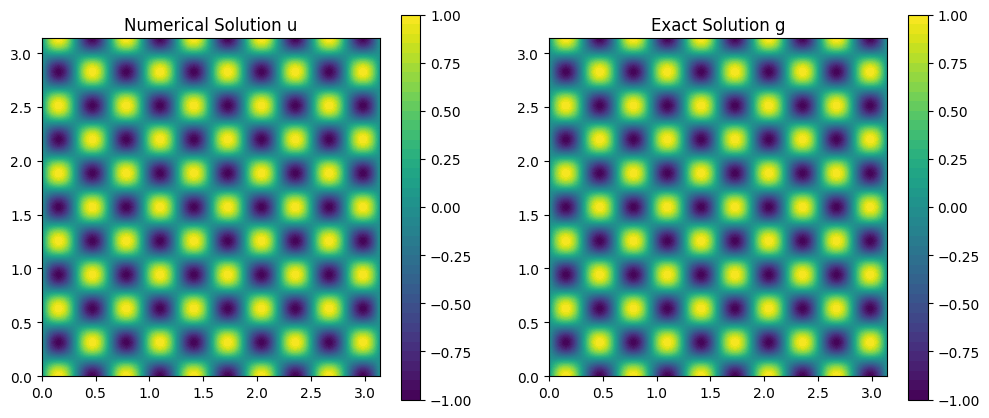

In [5]:
mesh = RectangleMesh(Point(0, 0), Point(np.pi, np.pi), 500, 500)

V = FunctionSpace(mesh, 'P', 1)

g = Expression('sin(10 * x[0]) * cos(10 * x[1])', degree=2)
f = Expression('2 * 100 * sin(10 * x[0]) * cos(10 * x[1])', degree=2)

bc = DirichletBC(V, g, 'on_boundary')

u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx
L = f * v * dx

u_sol = Function(V)
solve(a == L, u_sol, bc)

exact_solution = interpolate(g, V)

coords = mesh.coordinates()

values = u_sol.compute_vertex_values()

np.savez("solution.npz", coords=coords, values=values)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
u_sol_plot = plot(u_sol)
plt.title('Numerical Solution u')
plt.colorbar(u_sol_plot)

plt.subplot(1, 2, 2)
exact_solution_plot = plot(exact_solution)
plt.title('Exact Solution g')
plt.colorbar(exact_solution_plot)

plt.show()

In [13]:
grid_sizes = [20, 30, 50, 75, 100, 150, 200, 300, 400, 500, 600, 750, 1000]
errors_L2 = []
errors_C = []
errors_H1 = []
hs = []

for n in grid_sizes:
    mesh = RectangleMesh(Point(0, 0), Point(np.pi, np.pi), n, n)
    V = FunctionSpace(mesh, 'P', 1)

    g = Expression('sin(10 * x[0]) * cos(10 * x[1])', degree=2)
    f = Expression('2 * 100 * sin(10 * x[0]) * cos(10 * x[1])', degree=2)

    bc = DirichletBC(V, g, 'on_boundary')

    u = TrialFunction(V)
    v = TestFunction(V)
    a = dot(grad(u), grad(v)) * dx
    L = f * v * dx

    u_sol = Function(V)
    solve(a == L, u_sol, bc)

    exact_solution = interpolate(g, V)

    # Вычисление ошибок в разных нормах
    error_L2 = errornorm(exact_solution, u_sol, norm_type="L2")
    error_C = np.max(np.abs(u_sol.vector().get_local() - exact_solution.vector().get_local()))
    error_H1 = errornorm(exact_solution, u_sol, norm_type="H1")

    errors_L2.append(error_L2)
    errors_C.append(error_C)
    errors_H1.append(error_H1)
    hs.append(np.pi / n)

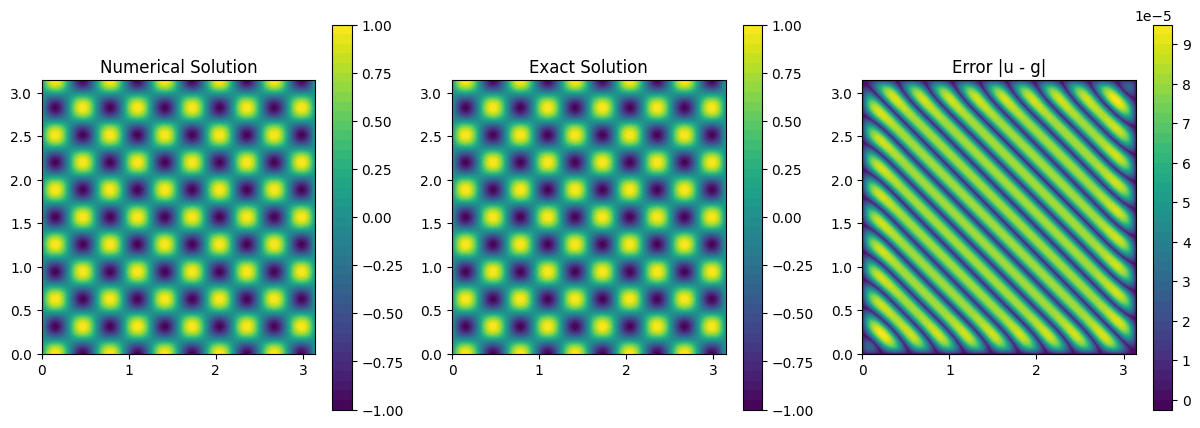

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
u_plt = plot(u_sol)
plt.title('Numerical Solution')
plt.colorbar(u_plt)

plt.subplot(1, 3, 2)
exact_plt = plot(exact_solution)
plt.title('Exact Solution')
plt.colorbar(exact_plt)

plt.subplot(1, 3, 3)
error_plot = plot(abs(u_sol - exact_solution))
plt.title('Error |u - g|')
plt.colorbar(error_plot)

plt.show()

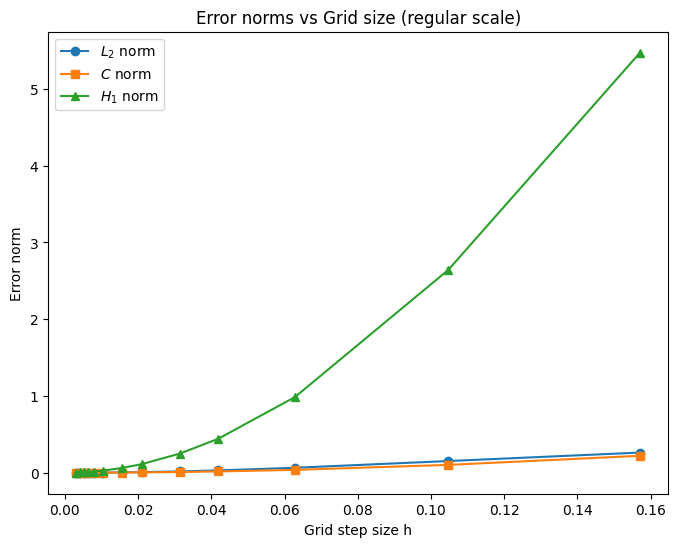

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(hs, errors_L2, marker='o', label=r'$L_2$ norm')
plt.plot(hs, errors_C, marker='s', label=r'$C$ norm')
plt.plot(hs, errors_H1, marker='^', label=r'$H_1$ norm')

plt.xlabel("Grid step size h")
plt.ylabel("Error norm")
plt.legend()
plt.title("Error norms vs Grid size (regular scale)")
plt.show()

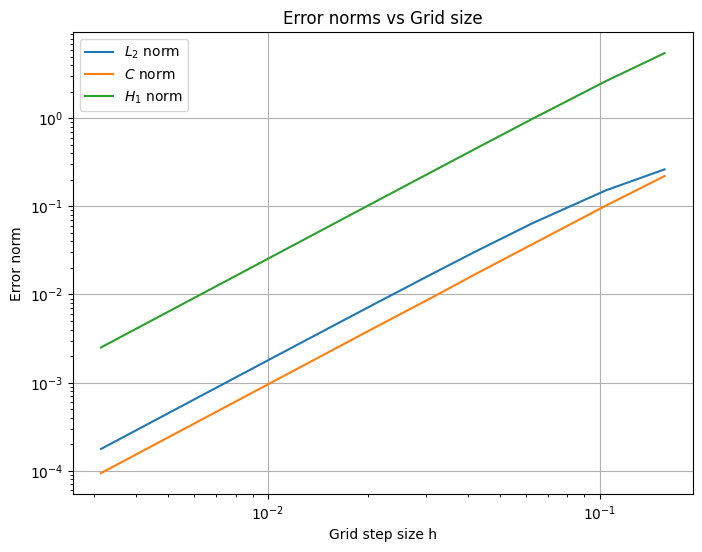

In [16]:
plt.figure(figsize=(8, 6))
plt.loglog(hs, errors_L2, label=r'$L_2$ norm')
plt.loglog(hs, errors_C, label=r'$C$ norm')
plt.loglog(hs, errors_H1, label=r'$H_1$ norm')

plt.xlabel("Grid step size h")
plt.ylabel("Error norm")
plt.legend()
plt.grid()
plt.title("Error norms vs Grid size")
plt.show()